# Film Plot Synopses as Predictors of Critical Reception

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', color_codes=True)

import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle

import pyLDAvis
import pyLDAvis.gensim

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

import xgboost as xgb
from xgboost import XGBClassifier
from patsy import dmatrices

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Sig

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defau

In [2]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a Kaggle dataset.

The best part of this kaggle dataset is that it provides 5k+ IMdB movie ID's, which we parse and pass to the Open Movie Database API for an even richer data set. Keys to this API cost a whole dollar. Here we parse out those IMdB ID's.

In [3]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

### Insert code into omdb api and turn each one into its own text file

This is where we persist our API queries to .txt files.
This prevents us from running into query limits and getting locked out of our dataset. Our API key has been removed from this notebook.

In [4]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

## Create new dataframe with relevant columns

We read the files containing information about the movies back into a pandas DataFrame, including the features we are interested in looking at:

In [5]:
#create empty dataframe with relevant columns

df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

We populate a DataFrame with the information from the kaggle dataset and the OMdB API Data:

In [6]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r")    #open up the movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text)    #turn string back to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'")    #clean up
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True)    #add to dataframe

This is what our new DataFrame looks like:

In [7]:
df.iloc[:3, :]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8


## Exploratory Data Analysis 

### Remove movies with null plots and ratings, convert ratings into binary

We drop the instances with null 'imdbRating', since that is our target variable. We then change this column into 'binary_target' which tells whether or not the 'imdbRating' is above the mean.

The number of instances with null 'Plot' was minimal, and therefore we could remove them from our dataframe without losing much data.

Lastly, we replaced null values from the 'actor facebook likes' with the column's mean number of likes, rather than replacing them with zero or dropping the instances altogether. This allows us to do a log transformation on these features later on.

In [8]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)

In [9]:
#reset indices
df = df.reset_index()
df = df.drop(['index'], axis=1)
df[:3]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating,binary_target
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8,1
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1,1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8,1


### One-hot Encoding Genres

In [10]:
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

#create a list of lists, where each element is a list of a movie's classified genres
li = []
[li.append(df.iloc[i]['Genre'].split(', ')) for i in range(len(df))]

#adding columns to df for each genre, 1 represents the movie is classified under that genre, 0 is that it is not
for genre in final_genres:
    list = []
    [list.append(1) if genre in movie
    else list.append(0) for movie in li]
    df[genre] = list

### Creating a fresh DataFrame with Everything But Plot Text Features

In [11]:
main_df = pd.DataFrame()

genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
main_df.columns

Index(['Year', 'binary_target', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

Distribution of movie years:

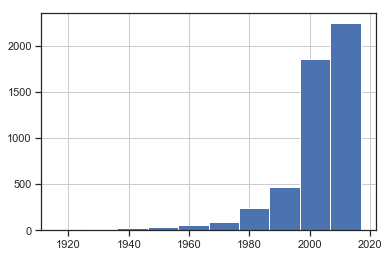

In [13]:
main_df.Year.hist()

Distribution of binary target:

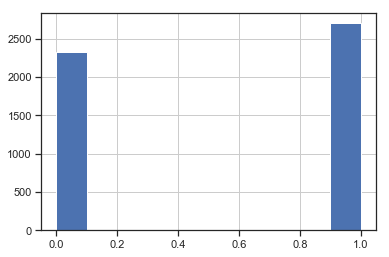

In [14]:
main_df.binary_target.hist()

### Log transforming "Actor Facebook Likes"

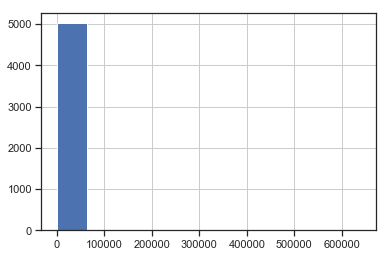

In [15]:
df.Actor_1_fb_likes.hist()

In [16]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

In [17]:
pd.Series(actor_likes).hist

<bound method hist_series of 0    0        6.908755
1       10.596660
2        9...
1    0        6.842683
1        8.517393
2        5...
2    0        6.752270
1        6.908755
2        5...
dtype: object>

In [18]:
main_df = main_df.join(actor_likes)
main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.908755,6.842683,6.752270
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10.596660,8.517393,6.908755
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.305741,5.976351,5.087596


In [19]:
# %matplotlib inline 
# import matplotlib
# df.plot.scatter(x='Actor_1_fb_likes',
#                     y='imdbRating') # Just spotting some outliers...this prompted us to log transform fb_likes

## Baseline Logistic Regression Model Without Plot-Text Features 

In [20]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588562
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Tue, 02 Apr 2019   Pseudo R-squ.:                  0.1485
Time:                        17:50:11   Log-Likelihood:                -2371.3
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                7.246e-160
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.6656      6.990     12.255      0.000      71.965   

0.6865079365079365

This gives us a sense of which variables are highly correlated with the output variable.
We drop the features that are deemed to be less important in determining the movie critical reviews. The standard is where the p-value is greater than .5

In [21]:
# Rerun LogReg by dropping the features with high p_values in the prior model (see above)

s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'Sci_Fi', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4013
Method:                           MLE   Df Model:                           15
Date:                Tue, 02 Apr 2019   Pseudo R-squ.:                  0.1482
Time:                        17:50:11   Log-Likelihood:                -2371.9
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                2.871e-166
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.2044      6.931     12.293      0.000      71.620   

0.6884920634920635

Moving forward, we will be working with the features below:

In [22]:
main_df.columns

Index(['Year', 'binary_target', 'Action', 'Animation', 'Biography', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Horror', 'Mystery', 'Romance',
       'Thriller', 'Actor_1_fb_likes_logged', 'Actor_2_fb_likes_logged',
       'Actor_3_fb_likes_logged'],
      dtype='object')

Looking at correlation matrices:

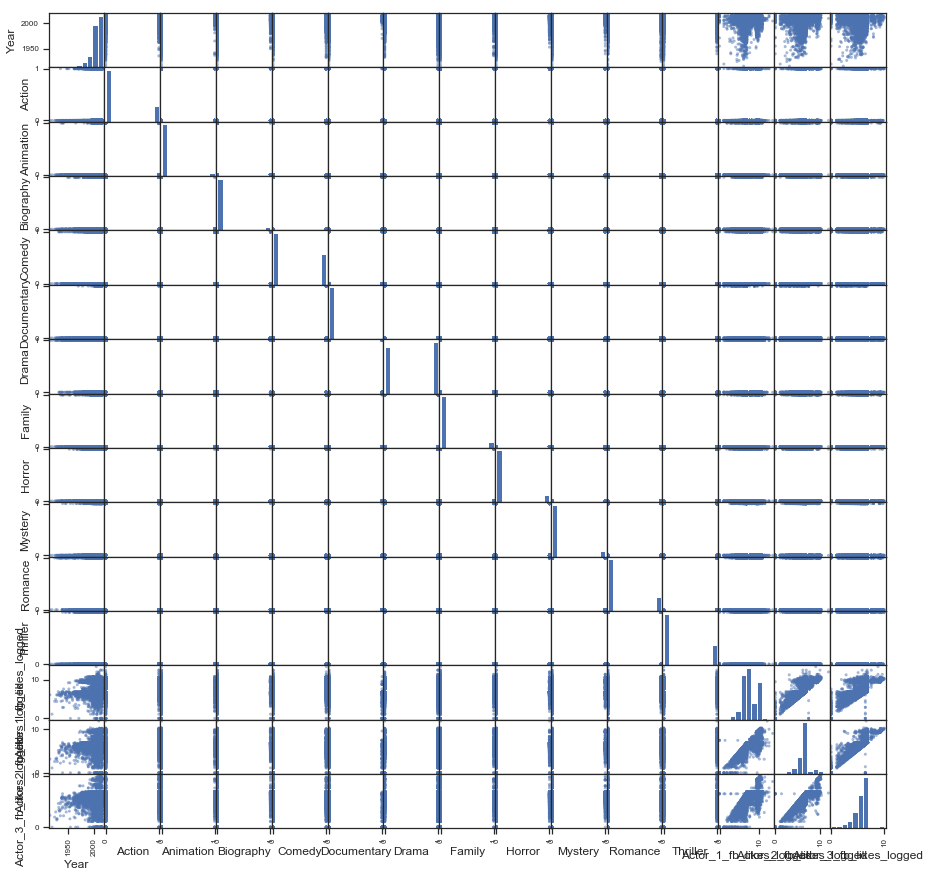

In [23]:
#Creating multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

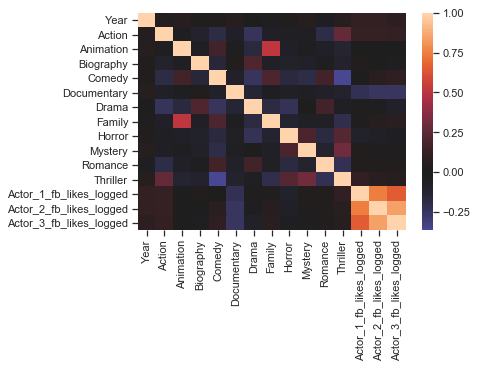

In [24]:
sns.heatmap(main_corr.corr(), center=0);


It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

# Incorporating Natural Language Processing with Plot Synopses

#### Setting up Lemmatization / Normalization Functions

In [25]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [26]:
def lemmatize(plot_list):
    lemmatized_plots = []
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower())   #make plot summary all lowercase and lemmatize
        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        
        lemmatizer = WordNetLemmatizer()
        
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower]    #lemmatize each word based on part of speech
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        #filter for words that match regex pattern
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))    #define regular expression pattern
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        #filter out stop words
        stop_words = set(stopwords.words('english'))
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        
        lemmatized_plots.append(lemmatized_string)
        
        
    return lemmatized_plots

### Running the Lemmatizer

In [27]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all the plots.
plots = lemmatize(all_plots) # Lemmatize.

In [28]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1056)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>


False

### Vectorizing Plots

In [29]:
#term frequency = number of times a word appears in a document / number of words in document
#inverse document frequency = log base e(number of ducuments / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA - Clustering Documents by Topic

We ran a topic modeling algorithm over our corpus of text. 
"Gensim" clusters words that appear together frequently across several documents. The clusters can be interpreted as general themes, and each movie has weights of how much it belongs to each theme. These weights are then re-incorporated as features in our dataset.

In [30]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [31]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [32]:
NUM_TOPICS = 50 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('model5.gensim')

In [33]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

[(30, '0.062*"johnny" + 0.041*"jay" + 0.030*"game" + 0.021*"unfolds"'),
 (43, '0.023*"dress" + 0.013*"comedy" + 0.013*"world" + 0.012*"labor"'),
 (0, '0.015*"con" + 0.014*"political" + 0.012*"hank" + 0.011*"tape"'),
 (7, '0.069*"town" + 0.025*"small" + 0.022*"radio" + 0.014*"journalist"'),
 (32, '0.011*"home" + 0.010*"men" + 0.010*"year" + 0.010*"daughter"'),
 (19, '0.118*"school" + 0.067*"high" + 0.061*"student" + 0.025*"college"'),
 (4, '0.031*"crew" + 0.022*"film" + 0.016*"josh" + 0.014*"star"'),
 (18, '0.017*"begin" + 0.012*"life" + 0.012*"reality" + 0.010*"summer"'),
 (49, '0.042*"mom" + 0.035*"dad" + 0.030*"kid" + 0.018*"series"'),
 (45, '0.060*"war" + 0.032*"world" + 0.023*"fight" + 0.015*"stop"'),
 (34, '0.016*"art" + 0.013*"tom" + 0.011*"trip" + 0.011*"world"'),
 (13, '0.025*"family" + 0.013*"new" + 0.013*"living" + 0.011*"together"'),
 (42, '0.013*"find" + 0.012*"two" + 0.011*"life" + 0.011*"man"'),
 (1, '0.055*"nick" + 0.030*"mark" + 0.021*"comic" + 0.020*"oliver"'),
 (26, '

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
40     0.226577  0.040696       1        1  10.833776
36     0.203240  0.041325       2        1   7.079352
48     0.205919  0.028197       3        1   5.651343
25     0.162890 -0.020988       4        1   5.286251
5      0.154091  0.004901       5        1   4.083423
42     0.150898  0.009127       6        1   3.747777
27     0.105471  0.013191       7        1   3.178649
20     0.087132 -0.113221       8        1   2.985607
44     0.093222 -0.085434       9        1   2.979929
23     0.006237 -0.152640      10        1   2.530593
17     0.064646 -0.010883      11        1   2.358447
11    -0.022535 -0.187482      12        1   2.341854
18     0.104610  0.073444      13        1   2.103087
10     0.070350 -0.019304      14        1   2.009830
9      0.091332  0.031257      15        1   1.966722
3      0.106312  0.038424      16        1   1.755076
19     0.046104  0.121740      17        1   1.726402
46    -0.057029 -0.134302      18        1   1.720627
45    -0.081018 -0.204326      19        1   1.685120
32     0.060645 -0.022230      20        1   1.684414
41     0.064541  0.017558      21        1   1.631978
14    -0.014546 -0.059848      22        1   1.564402
35     0.010500 -0.041355      23        1   1.537581
31     0.047765  0.001813      24        1   1.521131
34     0.045266 -0.024615      25        1   1.462135
2      0.070593  0.036382      26        1   1.434675
28    -0.095678 -0.102191      27        1   1.427850
21     0.029197 -0.016016      28        1   1.370815
13     0.020296  0.047030      29        1   1.349079
39    -0.089285 -0.107755      30        1   1.344914
37     0.006509  0.020885      31        1   1.303819
16    -0.024461 -0.050518      32        1   1.296773
33    -0.086358 -0.037624      33        1   1.096882
47    -0.043380  0.041831      34        1   1.082867
4     -0.084590  0.024347      35        1   1.057486
22    -0.138487 -0.117767      36        1   1.042372
0     -0.016667  0.091381      37        1   1.030190
15    -0.039501  0.094075      38        1   0.994115
6     -0.021586  0.067868      39        1   0.908604
24    -0.031938  0.060527      40        1   0.896370
26    -0.122895  0.061441      41        1   0.835351
38    -0.155692 -0.011443      42        1   0.785854
43    -0.095584  0.067652      43        1   0.761041
8     -0.126789 -0.025883      44        1   0.760833
49    -0.098279  0.098303      45        1   0.760304
1     -0.111613  0.122060      46        1   0.742924
7     -0.149907  0.048454      47        1   0.735828
29    -0.147594  0.090829      48        1   0.547145
12    -0.176560  0.079671      49        1   0.525317
30    -0.202370  0.071416      50        1   0.483092, topic_info=     Category         Freq           Term        Total  loglift  logprob
359   Default   565.000000         school   565.000000  30.0000  30.0000
658   Default   541.000000           town   541.000000  29.0000  29.0000
2124  Default   491.000000           film   491.000000  28.0000  28.0000
230   Default   413.000000            war   413.000000  27.0000  27.0000
607   Default   351.000000           high   351.000000  26.0000  26.0000
544   Default   412.000000           team   412.000000  25.0000  25.0000
2141  Default   291.000000        student   291.000000  24.0000  24.0000
313   Default   605.000000         mother   605.000000  23.0000  23.0000
212   Default  2050.000000           life  2050.000000  22.0000  22.0000
1149  Default  1091.000000         family  1091.000000  21.0000  21.0000
244   Default   835.000000         father   835.000000  20.0000  20.0000
68    Default   854.000000          world   854.000000  19.0000  19.0000
332   Default   229.000000          earth   229.000000  18.0000  18.0000
127   Default   416.000000           city   416.000000  17.0000  17.0000
696   Default   556.000000           girl   556.000000

In [35]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(50)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [36]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.05484,0.000000,0.000000,0.080622,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.672252,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.217882,0.0,...,0.0,0.000000,0.00000,0.017911,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.143767,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.053228,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.080153,0.00000,0.000000,0.000000,0.000000,0.0,0.330110,0.0,0.0


### Joining GenSim Results with Vectorized Plot Synopses

In [37]:
df = main_df.join(tm)
len(df.columns)

66

In [38]:
# df = tfidf_df.join(tm)

In [39]:
df.head()

,Year,binary_target,Action,Animation,Biography,Comedy,Documentary,Drama,Family,Horror,...,40,41,42,43,44,45,46,47,48,49
0,2009,1,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.05484,0.000000,0.000000,0.080622,0.0,0.000000,0.0,0.0
1,2007,1,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.000000,0.672252,0.000000,0.0,0.000000,0.0,0.0
2,2015,1,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.017911,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,2012,1,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.053228,0.0,0.0
4,2012,1,1,0,0,0,0,0,0,0,...,0.0,0.080153,0.00000,0.000000,0.000000,0.000000,0.0,0.330110,0.0,0.0


# Model Building

In [40]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Train-test split on X_scaled:

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.2)

## Baselining 

In [42]:
dc = DummyClassifier().fit(X_train, y_train)

In [43]:
accuracy_score(y_test,dc.predict(X_test))

0.5337301587301587

We see that the baseline model produces a 49.9% accuracy score. We hope to approve upon this model.

Dimensionality Reduction with SVD - For the PlotText Data:

In [44]:
svd = TruncatedSVD(n_components=50, n_iter=3, random_state=42)
X_train_pca = pd.DataFrame(svd.fit_transform(X_train))
print(svd.explained_variance_ratio_.sum())

0.8731603110899081


Next we'll try a simple Gaussian Naive Bayes Model:

In [45]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)
y_preds = clf.predict(pd.DataFrame(svd.transform(X_test)))
print(metrics.classification_report(y_test, y_preds))
test_accuracy = accuracy_score(y_test,y_preds)
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       448
           1       0.66      0.69      0.67       560

   micro avg       0.63      0.63      0.63      1008
   macro avg       0.62      0.62      0.62      1008
weighted avg       0.63      0.63      0.63      1008

Test accuracy: 62.8%


Now we'll go nuts and try an XGBClassifier model. A boosted model seems to work better without PCA, so we'll drop it for this part.

In [46]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)#pd.DataFrame(svd.transform(X_test)))

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 75.35%
Test accuracy: 68.55%


In [47]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7574657206632653


In [48]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

AUC: 0.7574657206632653


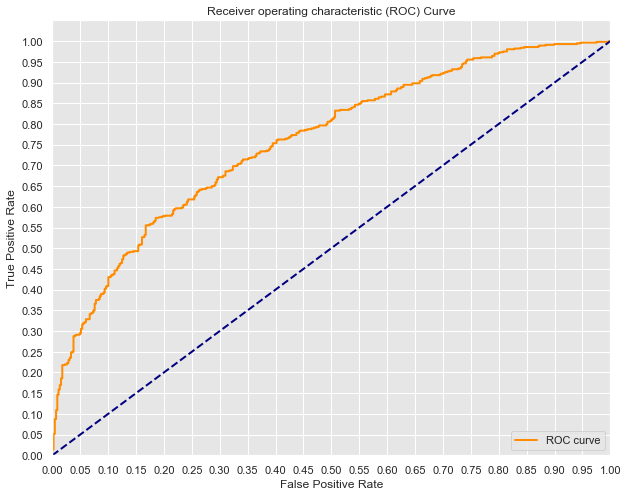

In [49]:
draw_roc_curve(fpr,tpr)

Looks like we are off to an okay start!

# Grid Searching for better parameters

In [50]:
# svd_components = [60,55,40]
# itera = [3, 5]

n_est = [50,80,100]
max_depth = [2,3,4]
learning_rates = [.08, .1, .15]

pipe = Pipeline([
#     ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

param_grid = [
    {
#         'reduce_dim__n_components': svd_components,
#         'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_depth,
        'classify__n_jobs': [-1],
        'classify__learning_rate': learning_rates
    }]

score = {'f1': 'f1', 
         'accuracy': 'accuracy'}

grid_adc = GridSearchCV(pipe, 
                        n_jobs=-1, 
                        param_grid=param_grid, 
                        scoring=score, 
                        refit='accuracy',
                        verbose=10)

grid_adc.fit(X_train, y_train)
grid_adc.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   34.7s finished


{'classify__learning_rate': 0.08,
 'classify__max_depth': 3,
 'classify__n_estimators': 80,
 'classify__n_jobs': -1}

Check the GridSearch results:

In [51]:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

0.6815476190476191

In [52]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

AUC: 0.7577985491071428


<Figure size 432x288 with 0 Axes>

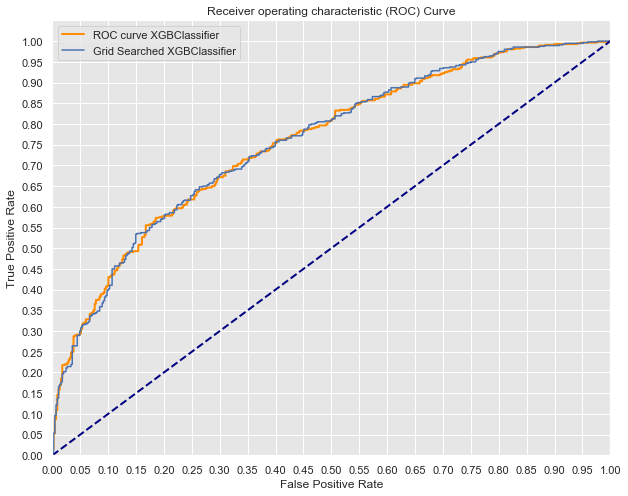

In [53]:
plt.figure(0).clf()
plt.figure(figsize=(10,8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,
         label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Negligible improvement.